Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с данными по ВВП Ганы. Выполняйте все задания проекта в одном Jupyter-ноутбуке.

In [1]:
from typing import Callable
from warnings import filterwarnings

import jupyter_black
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [2]:
filterwarnings("ignore")

In [3]:
jupyter_black.load(lab=False, line_length=79)

<IPython.core.display.Javascript object>

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

# Статистические модели прогнозирования

In [6]:
df = pd.read_csv("ghana_gdp.csv", parse_dates=["year"], index_col="year")

In [7]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [8]:
df.tail()

,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [9]:
df.size

62

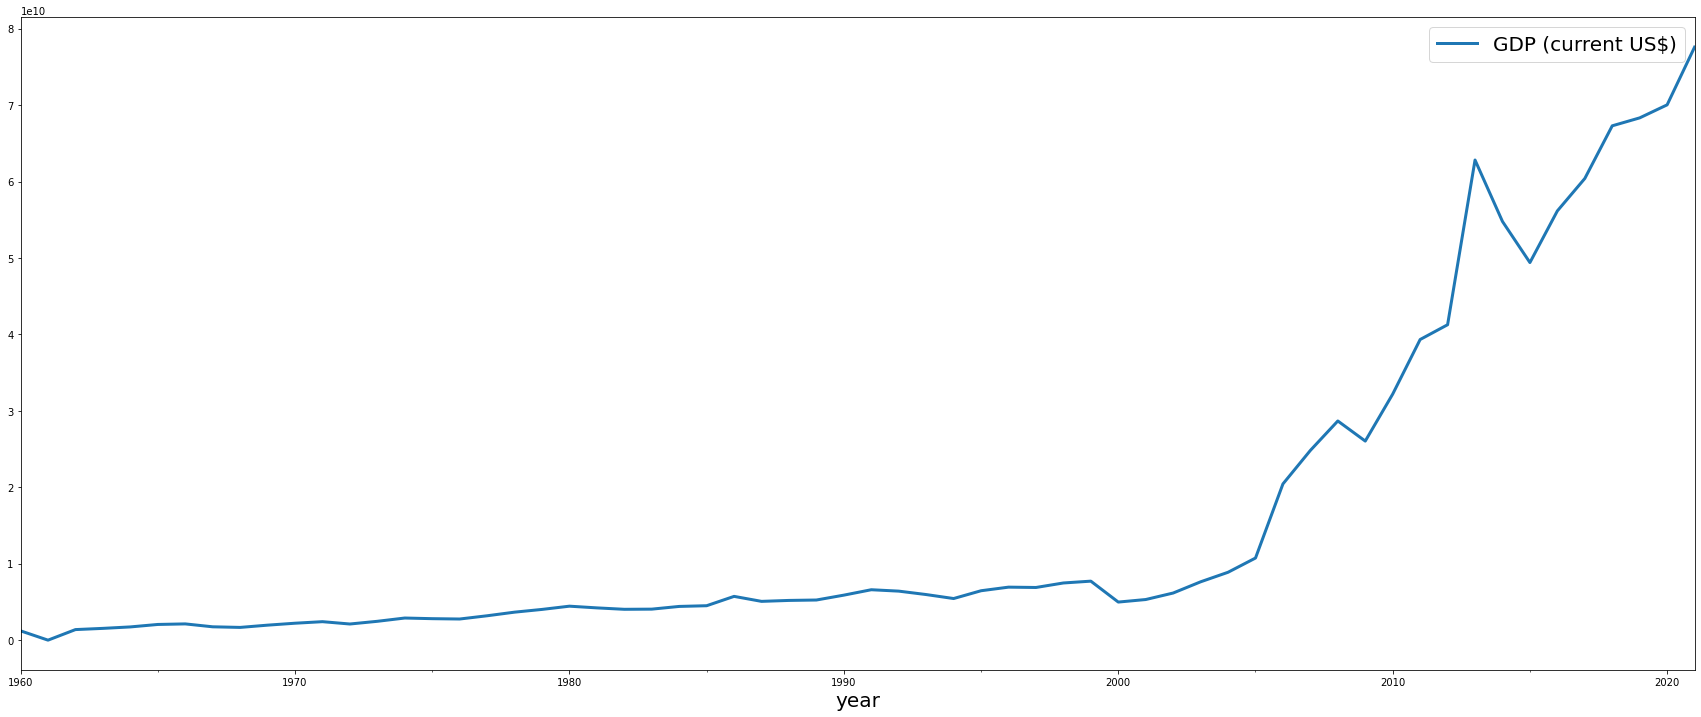

In [10]:
df.plot()
plt.show()

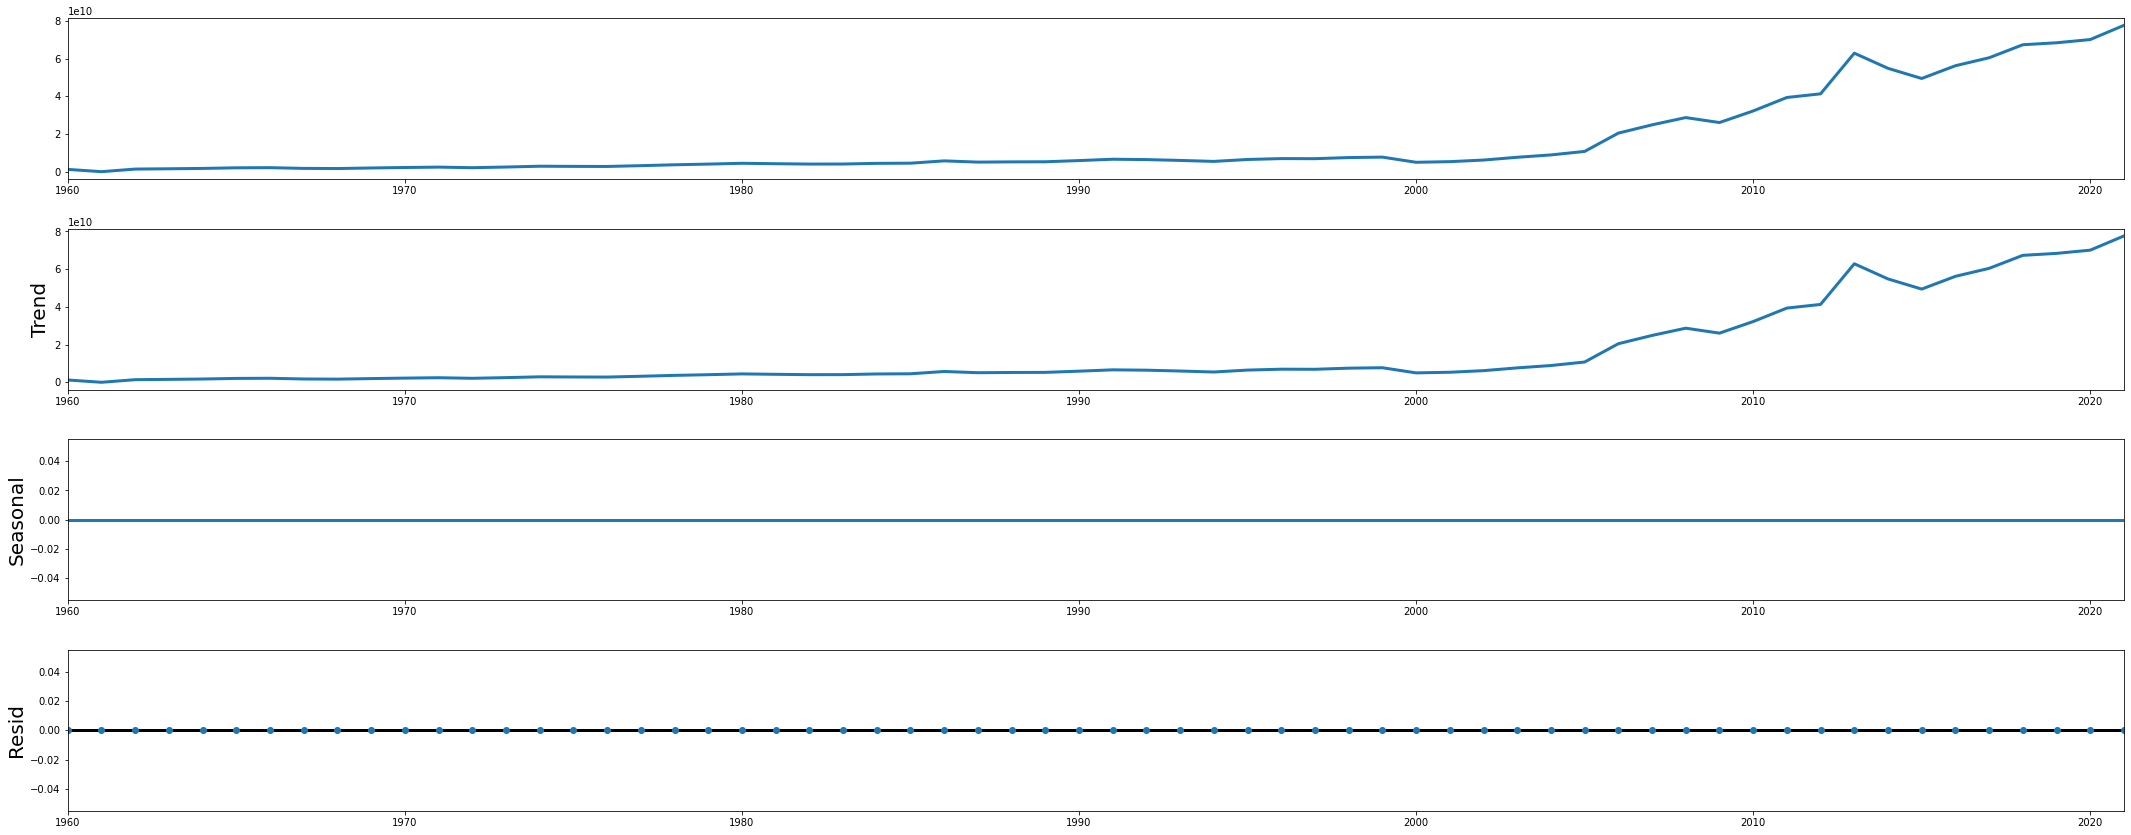

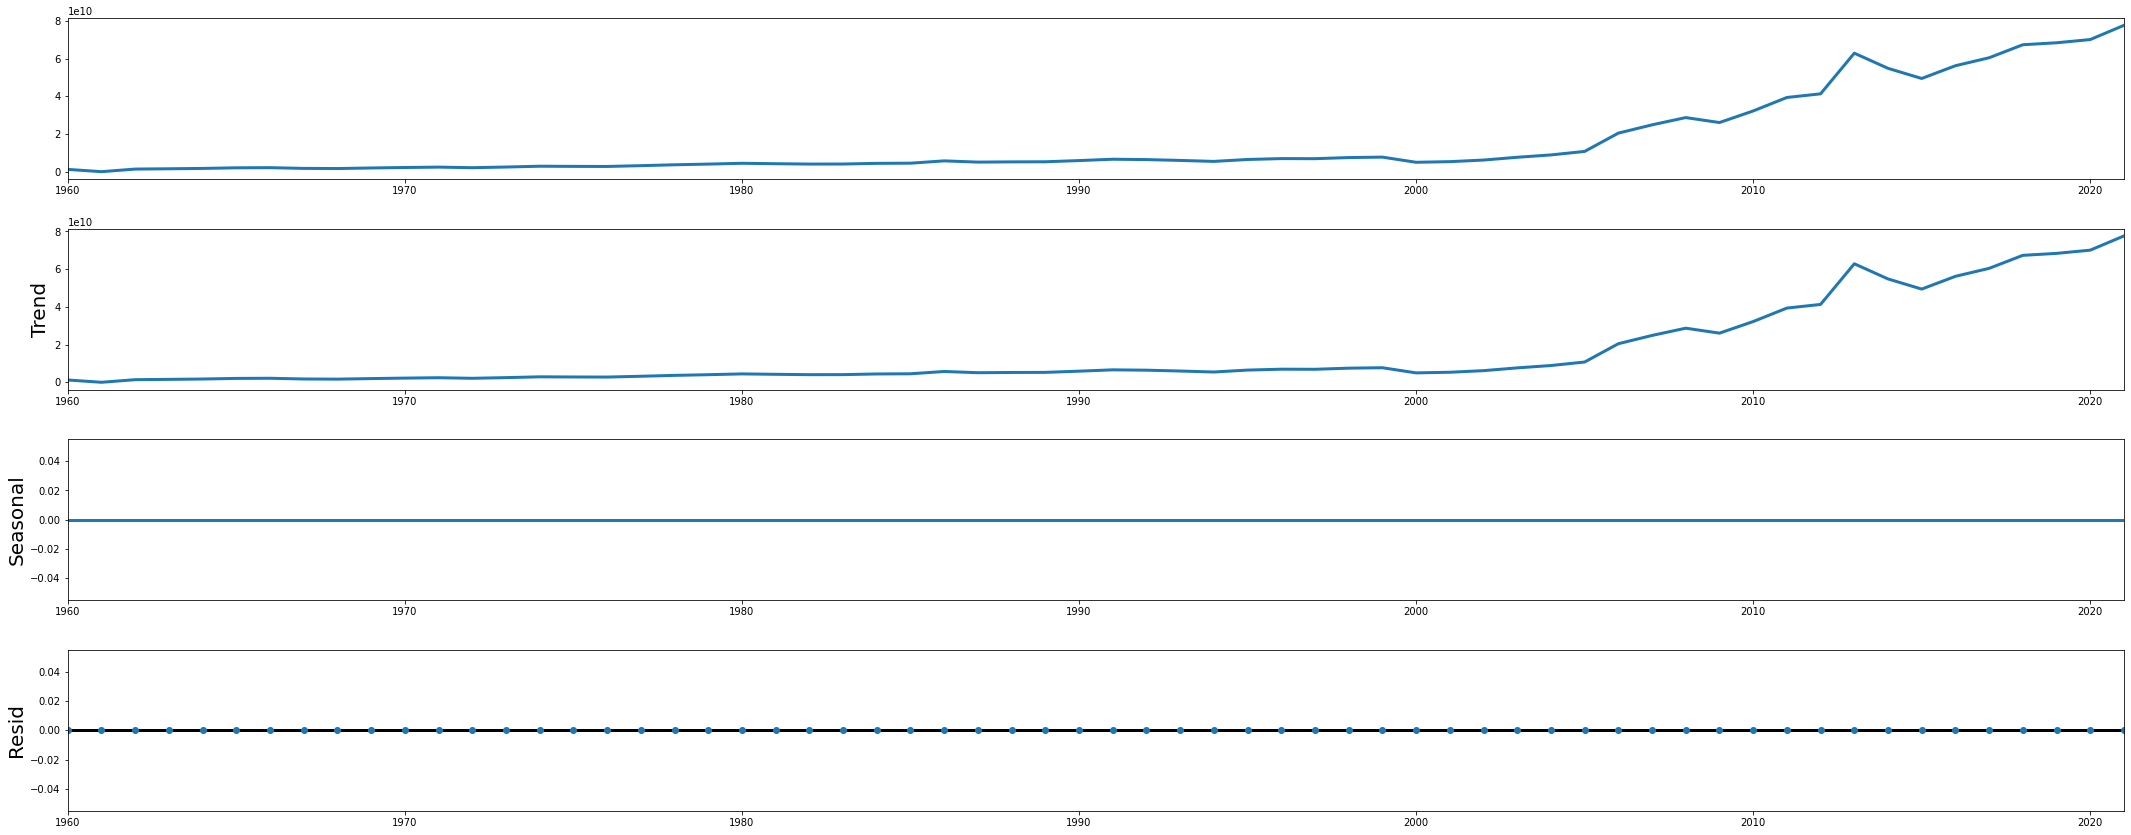

In [11]:
seasonal_decompose(df).plot()

Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.

In [12]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

Постройте модель скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

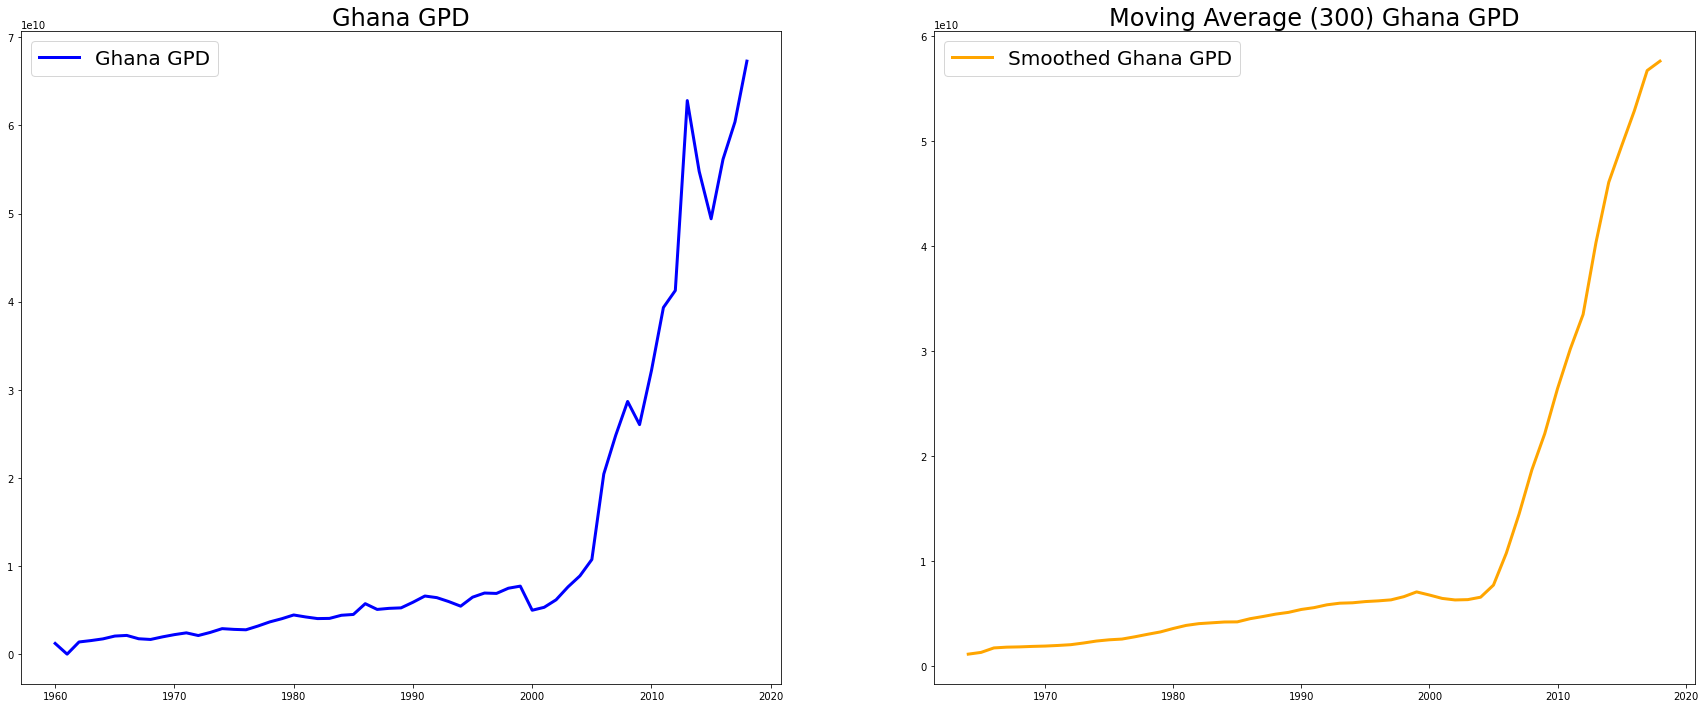

In [13]:
fig, ax = plt.subplots(1, 2)

# Окно в 5 лет (Window = 5)
ax[0].plot(df_train["GDP (current US$)"], color="blue", label="Ghana GPD")
ax[0].set_title("Ghana GPD")
ax[0].legend()

ax[1].plot(
    df_train["GDP (current US$)"].rolling(window=5).mean(),
    color="orange",
    label="Smoothed Ghana GPD",
)
ax[1].set_title("Moving Average (300) Ghana GPD")
ax[1].legend()

plt.show()

Оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA. Выберите парамeтры p и q по коррелограммам ACF и PACF. Также постройте модель с параметрами, ближайшими к p и q, и сравните коэффициент AIC или подберите наилучшие параметры с помощью pmdarima, как в скринкасте.

In [14]:
def diff_n(series: pd.Series, n: int) -> pd.Series:
    """
    Дифференцирует временной ряд заданного порядка.

    Args:
        series: временной ряд
        n: порядок дифференцирования

    Returns:
        продифференцированный ряд заданного порядка
    """
    for i in range(n):
        series = series.diff().dropna()

    return series

In [15]:
def is_stationary(series: pd.Series) -> bool:
    """
    Определяет, является ли ряд стационарным.

    Args:
        series: временной ряд

    Returns:
        True, если ряд является стационарным, иначе False
    """
    test = adfuller(series.dropna())
    print("adf: ", test[0])
    print("p-value: ", test[1])
    print("Critical values: ", test[4])
    return test[0] <= test[4]["5%"]

In [16]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.6529066974885412
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

Ряд нестационарный, поэтому нам нужна модель ARIMA.

In [17]:
is_stationary(diff_n(df_train["GDP (current US$)"], 1))

adf:  -1.67024830383208
p-value:  0.446502932971388
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [18]:
is_stationary(diff_n(df_train["GDP (current US$)"], 2))

adf:  -2.6408690561284893
p-value:  0.08484116917837681
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}


False

In [19]:
is_stationary(diff_n(df_train["GDP (current US$)"], 3))

adf:  -4.779623784828548
p-value:  5.948327640224507e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


True

Ряд является интегрированным рядом третьего порядка.

Теперь определим порядок моделей AR и MA по графику частичной автокорреляции.

In [20]:
d = 3

In [21]:
def plot_correlogram(
    series: pd.Series, plot_function: Callable, ax: matplotlib.axes.Axes
) -> None:
    """
    Строит коррелограмму acf или pacf для временного ряда.

    Args:
        series: временной ряд
        corr_function: функция построения коррелограммы
        ax: оси, на которых нужно построить коррелограмму

    Raises:
        ValueError, если функция построения коррелограммы неправильная
    """
    if plot_function.__name__ == "plot_acf":
        plot_function(series, lags=25, ax=ax, zero=False)
    elif plot_function.__name__ == "plot_pacf":
        plot_function(series, lags=25, ax=ax, method="ywm", zero=False)
    else:
        raise ValueError("Incorrect plot function")

    ax.xaxis.set_ticks(np.arange(0, 26, 1))
    ax.yaxis.set_ticks(np.arange(-1.0, 1.0, 0.1))
    ax.grid()

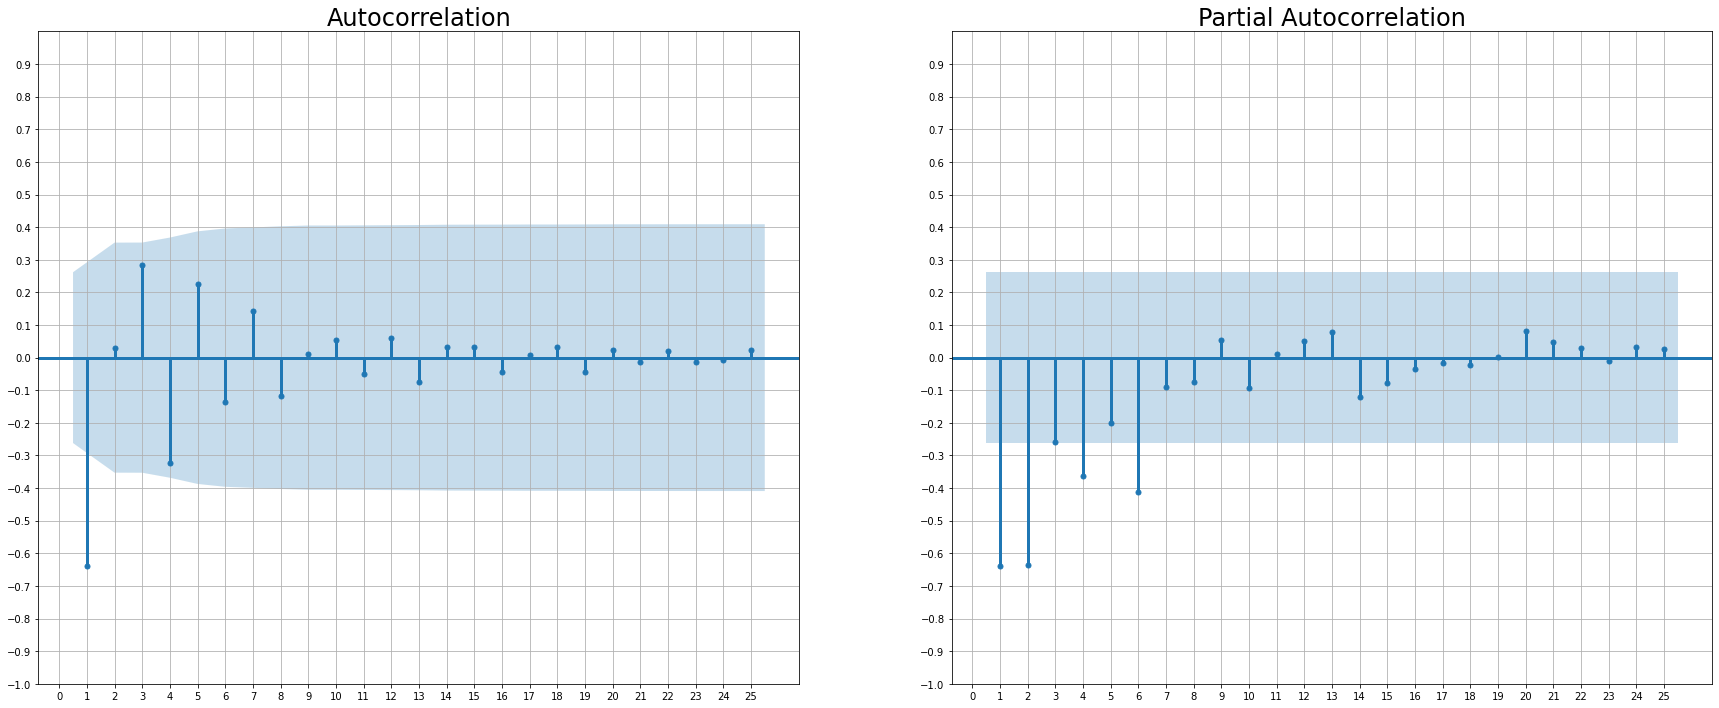

In [22]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_acf, ax[0])
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_pacf, ax[1])
plt.show()

На графике автокорреляции последний лаг, отличный от нуля – лаг № 1. Соответственно, порядок модели MA будет 1.
На графике частичной автокорреляции последний лаг, отличный от нуля – лаг № 6. Соответственно, порядок модели AR будет 6.

In [23]:
p = 6
q = 1

Постройте модель с наилучшими параметрами и выполните предсказание на три года.

In [24]:
arima_model = ARIMA(df_train["GDP (current US$)"], order=(p, d, q))

In [25]:
arima_model_fit = arima_model.fit()

In [26]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Fri, 27 Jan 2023   AIC                           2629.140
Time:                        08:55:05   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.943      0.000      -2.013      -1.402
ar.L3         -1.5727      0.205     -7.660      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.715      0.000      -1.924      -1.373
ar.L5         -1.2769      0.159     -8.022      0.000      -1.589      -0.965
ar.L6         -0.8854      0.148     -5.976      0.000      -1.176      -0.595
ma.L1         -0.5919      0.104     -5.672      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.05
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.69   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.63e+53. Standard errors may be unstable.
"""

In [27]:
df_pred = pd.concat(
    [
        df["GDP (current US$)"],
        arima_model_fit.predict(start=df.index[0], end=df.index[-1]),
        arima_model_fit.get_forecast(
            len(df_test["GDP (current US$)"])
        ).conf_int(alpha=0.05),
    ],
    axis=1,
)

In [28]:
df_pred

,GDP (current US$),predicted_mean,lower GDP (current US$),upper GDP (current US$)
1960-01-01,1.217087e+09,0.000000e+00,NaN,NaN
1961-01-01,0.000000e+00,2.892060e+09,NaN,NaN
1962-01-01,1.382353e+09,-6.861462e+08,NaN,NaN
1963-01-01,1.540616e+09,2.298163e+09,NaN,NaN
1964-01-01,1.731092e+09,1.346869e+09,NaN,NaN
...,...,...,...,...
2017-01-01,6.040638e+10,5.961092e+10,NaN,NaN
2018-01-01,6.729928e+10,6.977281e+10,NaN,NaN
2019-01-01,6.833754e+10,6.902537e+10,6.328852e+10,7.476222e+10
2020-01-01,7.004320e+10,7.730172e+10,6.904224e+10,8.556119e+10


Отобразите результат графически.

In [143]:
def plot_forecast(df: pd.DataFrame, full: bool = True) -> None:
    """
    Строит график прогноза модели для временного ряда.

    Args:
        df: датафрейм с предсказаниями
        full: если False, то график строится только для тестовой выборки
    """
    if full:
        plt.plot(df.loc[df_train.index].iloc[:, 0], color="blue")
        plt.plot(
            df.loc[df_train.index].iloc[:, 1],
            color="orange",
            label="Predictions (train)",
        )

    plt.plot(df.loc[df_test.index].iloc[:, 0], color="blue", label="Actuals")

    plt.plot(
        df.loc[df_test.index].iloc[:, 1],
        color="red",
        label="Predictions (test)",
    )

    if df.shape[1] == 4:
        plt.plot(
            df.loc[df_test.index].iloc[:, 2].dropna(),
            color="green",
            linestyle="--",
            label="Confidence Intervals (95%)",
        )
        plt.plot(
            df.loc[df_test.index].iloc[:, 3].dropna(),
            color="green",
            linestyle="--",
        )

    plt.legend()

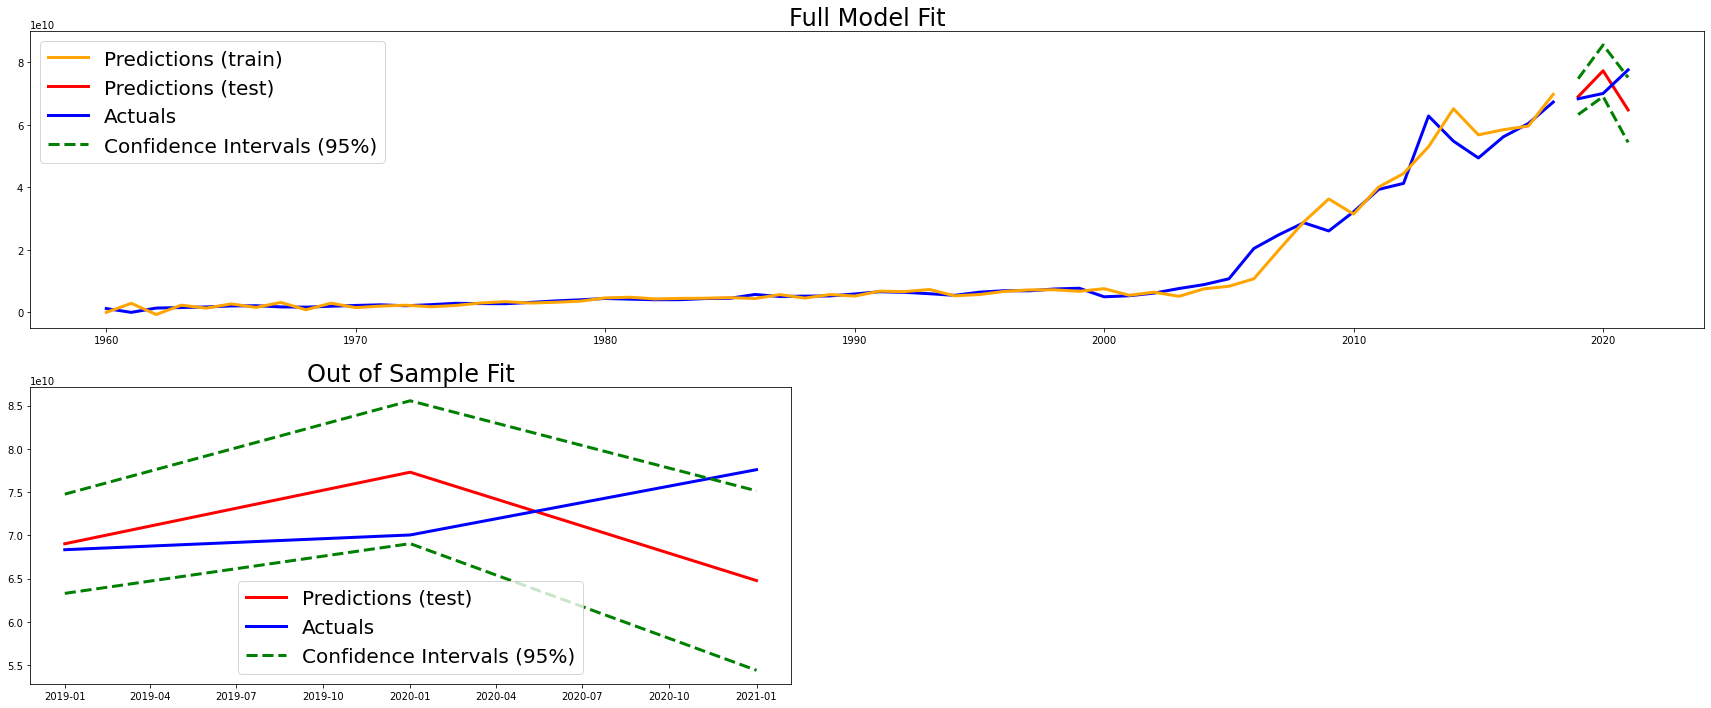

In [30]:
plt.subplot(2, 1, 1)
plot_forecast(df_pred)
plt.title("Full Model Fit")

plt.subplot(2, 2, 3)
plot_forecast(df_pred, full=False)
plt.title("Out of Sample Fit")

plt.show()

То же самое, но с использованием pmdarima.

In [31]:
smodel = auto_arima(
    df_train["GDP (current US$)"],
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=3,
    seasonal=False,
    test="adf",
    n_jobs=-1,
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.24 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.09 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.10 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.11 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.03 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.16 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.09 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.08 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 2.016 seconds


In [32]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 27 Jan 2023   AIC                           2659.231
Time:                        08:55:09   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.17e+56. Standard errors may be unstable.
"""

In [33]:
pred, forecast = smodel.predict(n_periods=3, return_conf_int=True)

In [34]:
df_test["prediction"] = pred
df_test["predictions_lower"] = forecast.T[0]
df_test["predictions_upper"] = forecast.T[1]

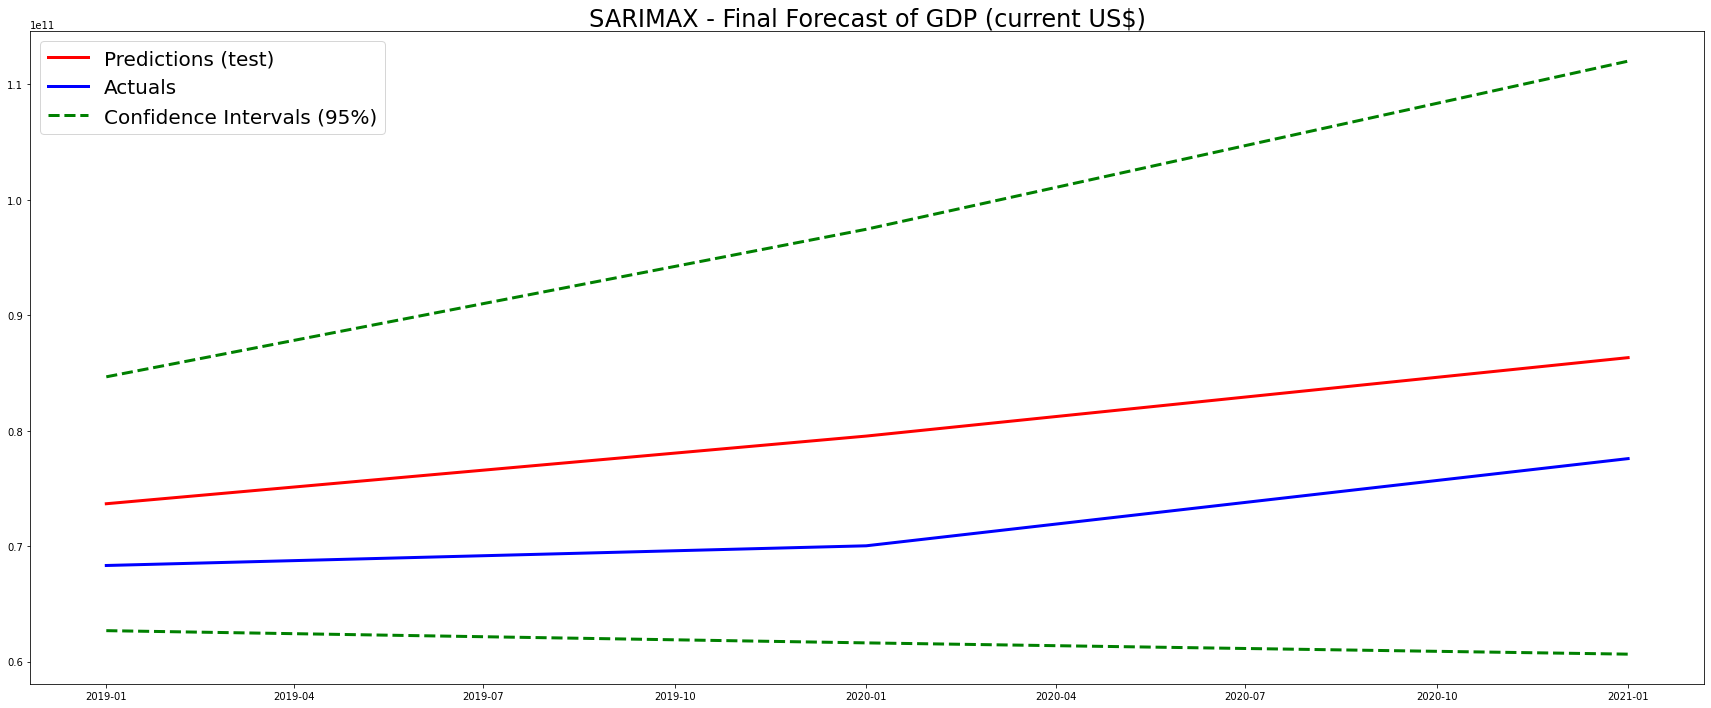

In [35]:
plot_forecast(df_test, full=False)
plt.title("SARIMAX - Final Forecast of GDP (current US$)")
plt.show()

Модель с параметрами, подобранными через pmdarima, даёт намного лучшие результаты, чем модель с параметрами, подобранными по сетке. Это происходит потому, что pmdarima приписывает некорректным комбинациям параметров AIC, равный бесконечности – соответственно, модель с некорректной комбинацией параметров не может оказаться наилучшей.

# Интерполяция и сэмплирование
## Задание 1
Проверьте данные на наличие пропущенных дат.

In [36]:
df.asfreq("AS")

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


## Задание 2
Проверьте данные на наличие пропущенных значений.

In [37]:
df.isnull().sum()

GDP (current US$)    0
dtype: int64

## Задание 3
Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [38]:
df["GDP (current US$)"] = df["GDP (current US$)"].apply(
    lambda x: np.nan if x == 0 else x
)

## Задание 4
Для заполнения пропусков выполните интерполяцию с использованием метода `interpolate`.

In [39]:
df = df.interpolate(method="linear")

In [40]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [41]:
print(f"{df.shape=:}")

df.shape=(62, 1)


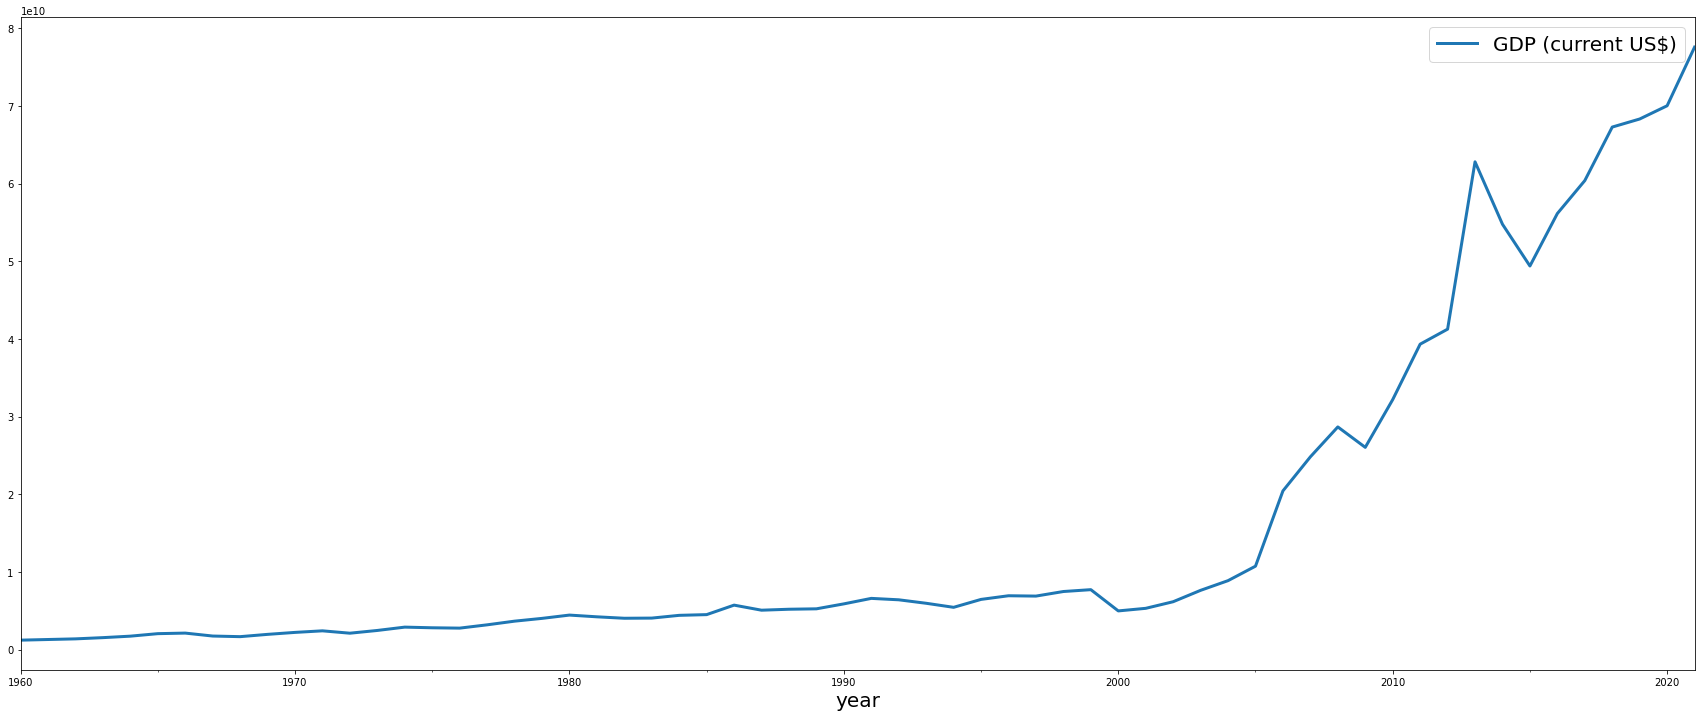

In [42]:
df.plot()
plt.show()

In [43]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

## Задание 6
Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.

In [44]:
is_stationary(df_train["GDP (current US$)"])

adf:  0.8030073326980101
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


False

Ряд нестационарный, поэтому нам нужна модель ARIMA.

In [45]:
is_stationary(diff_n(df_train["GDP (current US$)"], 1))

adf:  -1.825565224643604
p-value:  0.36784515276563223
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}


False

In [46]:
is_stationary(diff_n(df_train["GDP (current US$)"], 2))

adf:  -2.634634746007847
p-value:  0.08604813722197585
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}


False

In [47]:
is_stationary(diff_n(df_train["GDP (current US$)"], 3))

adf:  -4.8256036873040635
p-value:  4.857318076799029e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


True

Ряд является интегрированным рядом третьего порядка.

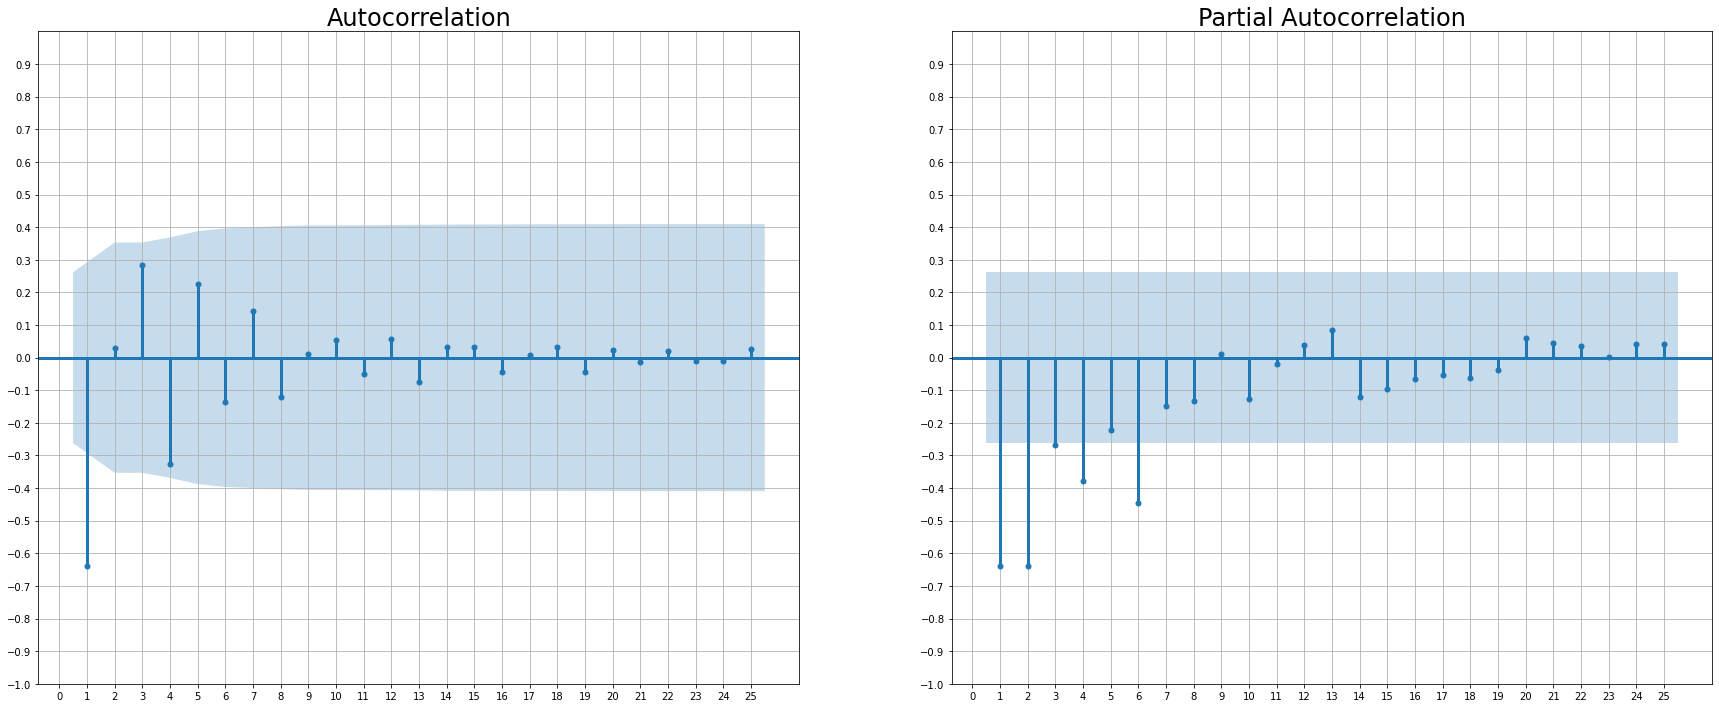

In [48]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_acf, ax[0])
plot_correlogram(diff_n(df_train["GDP (current US$)"], 3), plot_pacf, ax[1])
plt.show()

Графики корреляции не изменились, что ожидаемо.

Так как мы выяснили, что модель из pmdarima считает AIC корректнее и даёт лучшие предсказания, использовать будем именно её.

In [49]:
smodel = auto_arima(
    df_train["GDP (current US$)"],
    start_p=1,
    start_q=1,
    d=3,
    max_p=6,
    max_q=3,
    seasonal=False,
    test="adf",
    n_jobs=-1,
    error_action="ignore",
    trace=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.933, Time=0.09 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.03 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.04 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.226, Time=0.10 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2678.992, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.25 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.05 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2665.990, Time=0.06 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.762 seconds


# Задание 5
Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

In [50]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 27 Jan 2023   AIC                           2659.226
Time:                        08:55:15   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.64e+56. Standard errors may be unstable.
"""

AIC критерий незначительно упал (с 2659.231 до 2659.226). Такой небольшой прирост в качестве объясняется тем, что у нас было всего одно пропущенное значение.

In [51]:
pred, forecast = smodel.predict(n_periods=3, return_conf_int=True)

In [52]:
df_test["prediction"] = pred
df_test["predictions_lower"] = forecast.T[0]
df_test["predictions_upper"] = forecast.T[1]

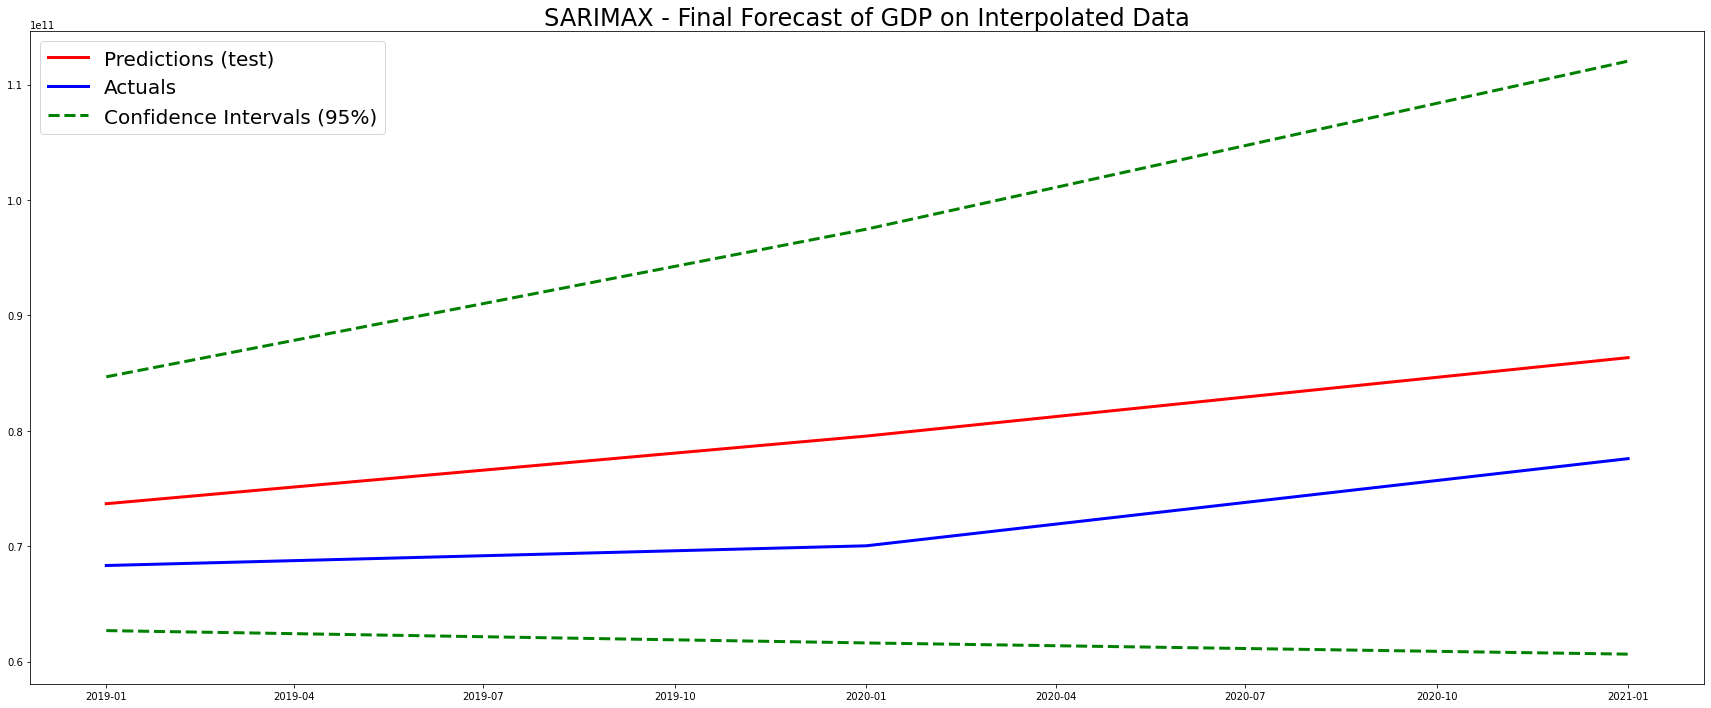

In [53]:
plot_forecast(df_test, full=False)
plt.title("SARIMAX - Final Forecast of GDP on Interpolated Data")
plt.show()

# Модели прогнозирования гетероскедастичности. Валидация временных рядов.
## Задание 1
Посчитайте волатильность для вашего временного ряда.

In [54]:
df["volatility"] = df["GDP (current US$)"].pct_change().abs()

In [55]:
df["volatility"].head()

year
1960-01-01         NaN
1961-01-01    0.067894
1962-01-01    0.063578
1963-01-01    0.114488
1964-01-01    0.123636
Name: volatility, dtype: float64

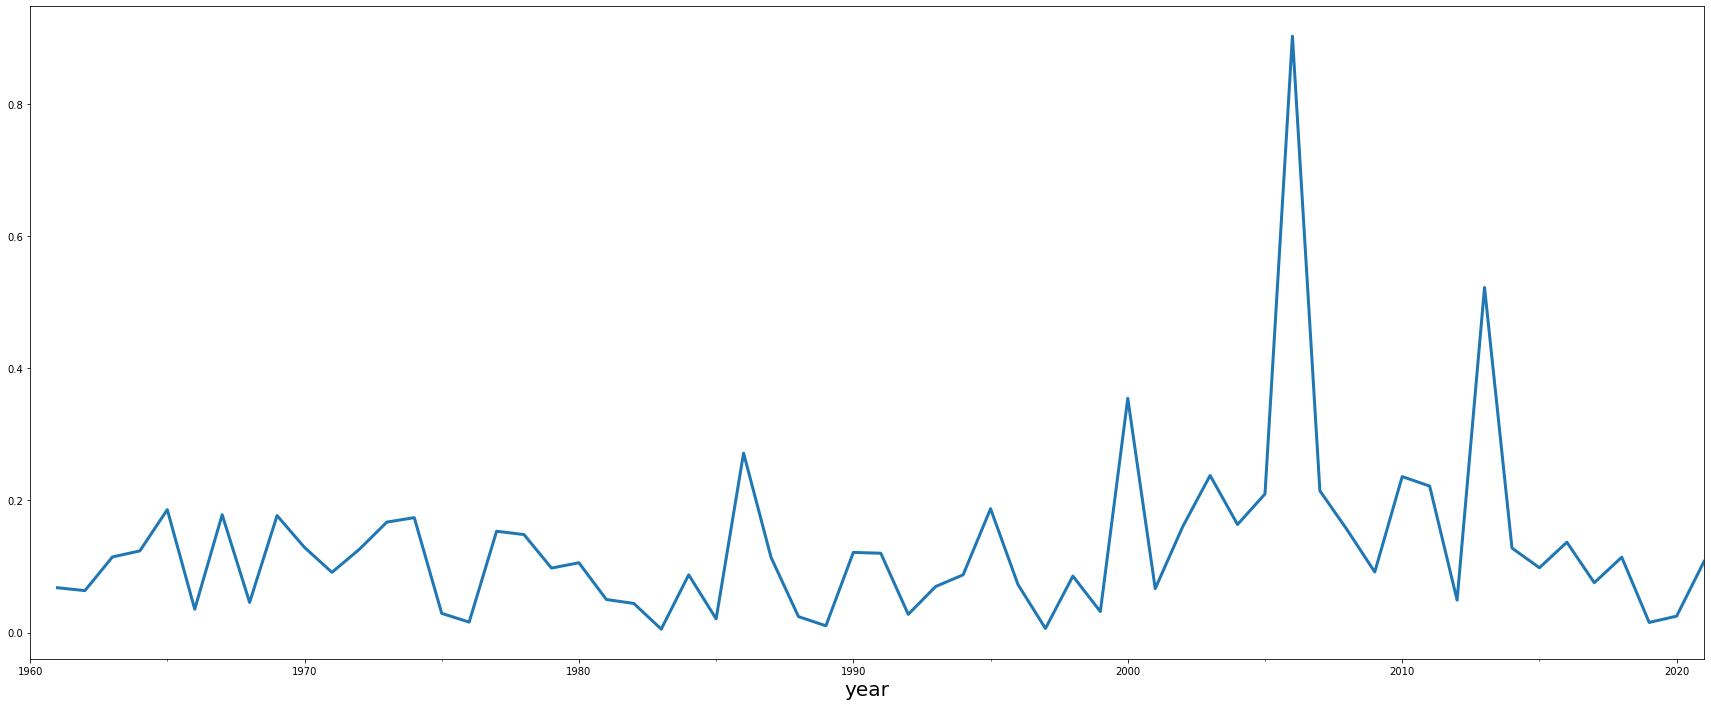

In [56]:
df["volatility"].plot()
plt.show()

По графику волатильности видим, что есть явные всплески дисперсии. Попробуем провести предсказание этой дисперсии.

In [57]:
df = df.drop(columns="GDP (current US$)")

In [58]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

In [59]:
is_stationary(df_train["volatility"][1:])

adf:  -6.725311059553776
p-value:  3.4014596148856737e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


True

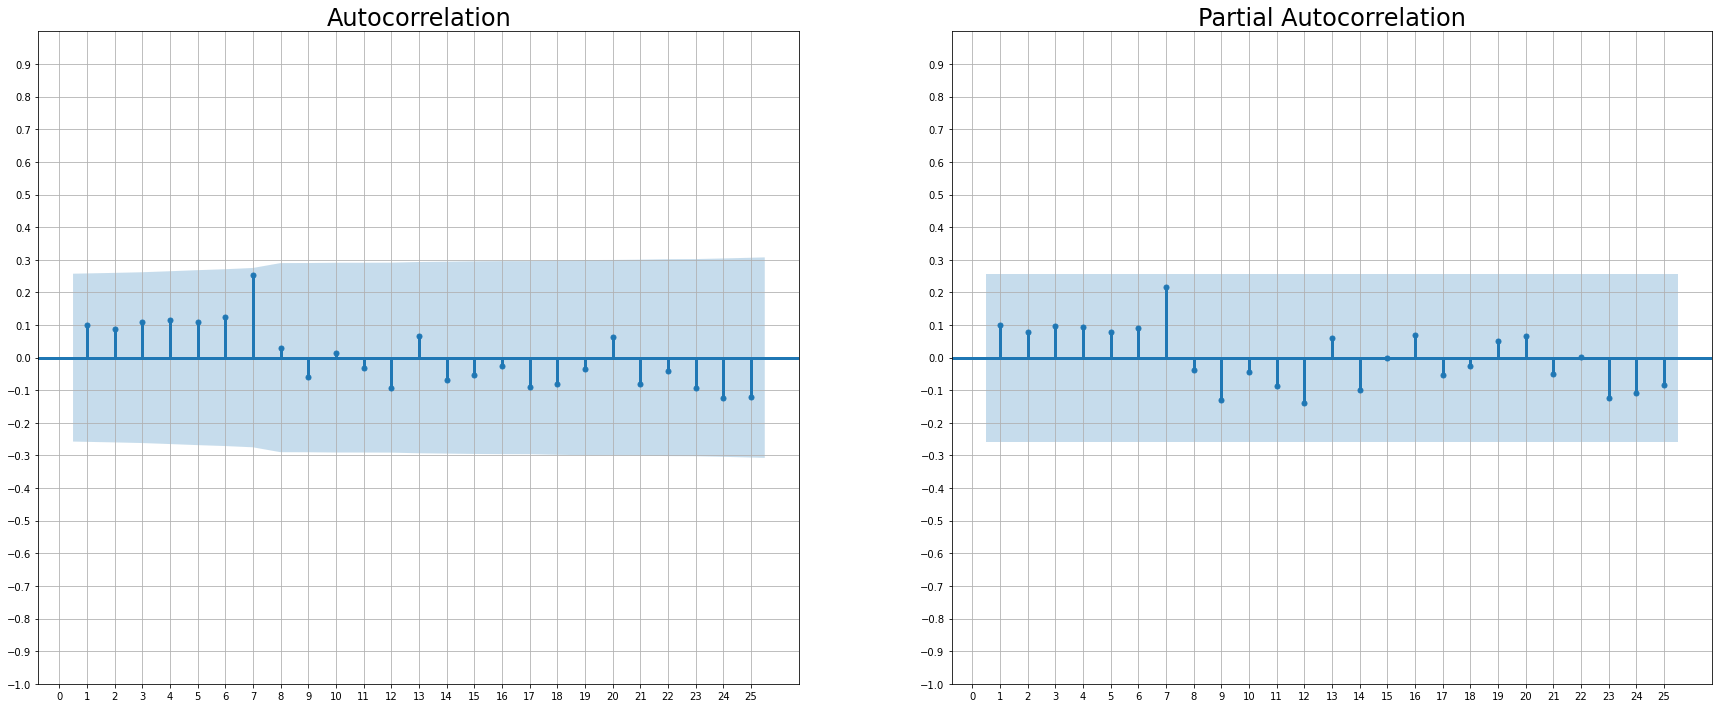

In [60]:
fig, ax = plt.subplots(1, 2)
plot_correlogram(df_train["volatility"][1:], plot_acf, ax[0])
plot_correlogram(df_train["volatility"][1:], plot_pacf, ax[1])
plt.show()

Как мы видим, на графике PACF нет ни одного лага, превышающего уровень значимости. Поэтому берём параметры модели p=2, q=2.

## Задание 2
Используйте GARCH-модель для предсказания волатильности.

In [61]:
model = arch_model(df["volatility"].dropna(), p=2, q=2, vol="GARCH")

In [62]:
model_results = model.fit(last_obs=df_test.index[0], update_freq=5)

Iteration:      5,   Func. Count:     45,   Neg. LLF: -39.53077028875127
Iteration:     10,   Func. Count:     81,   Neg. LLF: -40.393212252843874
Iteration:     15,   Func. Count:    118,   Neg. LLF: -40.50205797147106
Optimization terminated successfully    (Exit mode 0)
            Current function value: -40.50205823037112
            Iterations: 17
            Function evaluations: 131
            Gradient evaluations: 16


In [63]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                40.5021
Distribution:                  Normal   AIC:                          -69.0041
Method:            Maximum Likelihood   BIC:                          -56.6415
                                        No. Observations:                   58
Date:                Fri, Jan 27 2023   Df Residuals:                       57
Time:                        08:56:21   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1232  2.231e-02      5.522  3.351e-08 [7.947e-02,  0.167]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.6709e-04  1.724e-03      0.213      0.831 [-3.011e-03,3.745e-03]
alpha[1]       0.0000      0.109      0.000      1.000      [ -0.213,  0.213]
alpha[2]       0.0000      0.162      0.000      1.000      [ -0.317,  0.317]
beta[1]        1.0000      1.027      0.974      0.330      [ -1.013,  3.013]
beta[2]    9.8879e-17      0.996  9.931e-17      1.000      [ -1.951,  1.951]
=============================================================================

Covariance estimator: robust
"""

In [73]:
df_test["prediction"] = model_results.forecast(
    reindex=True
).residual_variance.loc[df_test.index]

In [74]:
mse = round(mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1]), 3)

mse=0.002


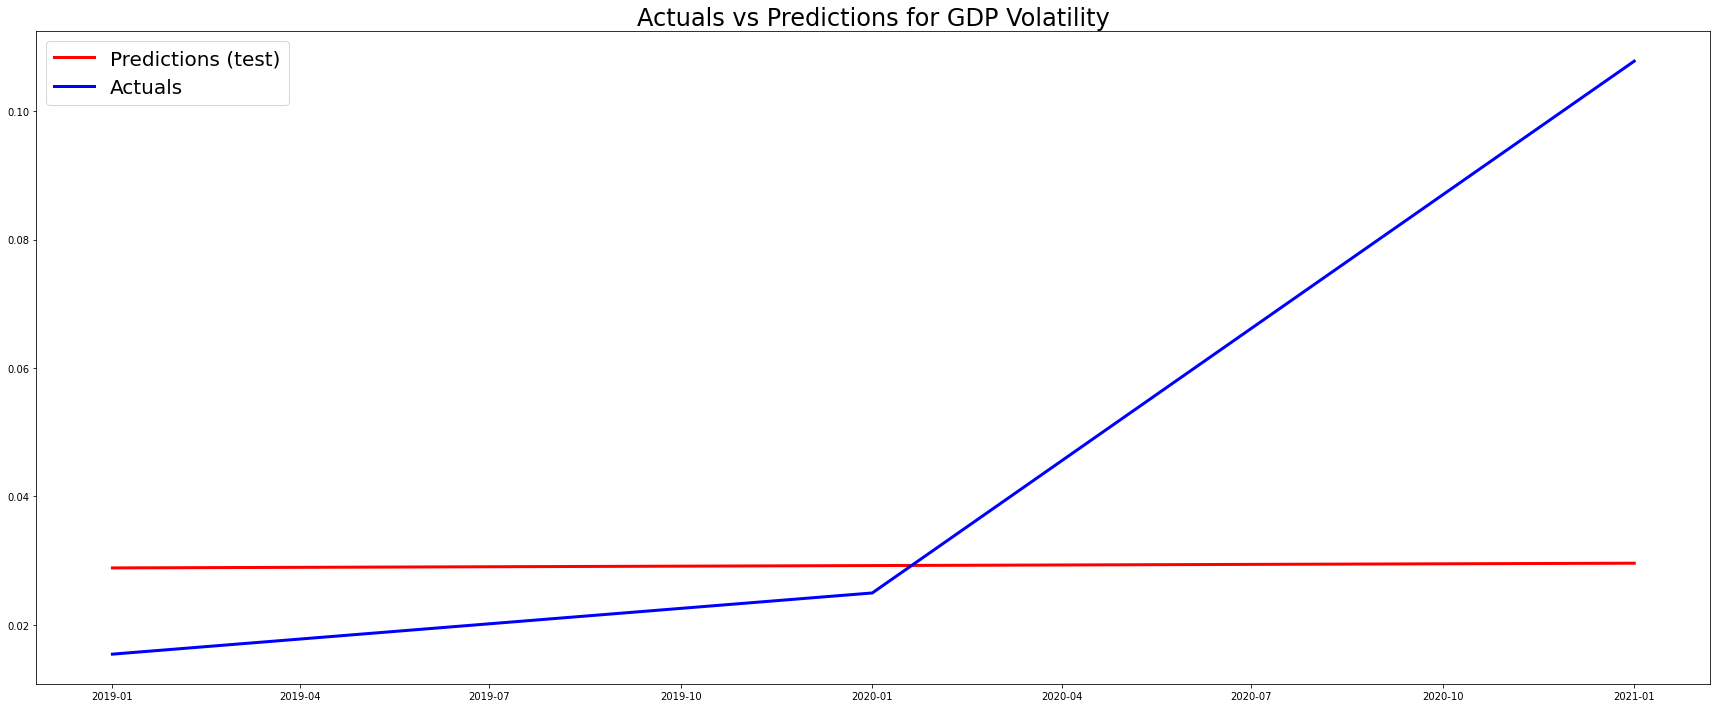

In [75]:
print(f"{mse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Predictions for GDP Volatility")
plt.show()

## Задание 3
Используйте линейную регрессию для получения прогноза.

In [76]:
X_train = pd.DataFrame(range(len(df_train)))
X_test = pd.DataFrame(range(len(df)))[-len(df_test) :]
y_train = df_train["volatility"].fillna(0)
y_test = df_test["volatility"]

In [77]:
regr = LinearRegression()

In [78]:
regr.fit(X_train, y_train)

LinearRegression()

In [79]:
df_test["prediction"] = regr.predict(X_test)

## Задание 4
Визуализируйте полученное предсказание вместе с фактическим значением.

In [80]:
mse = round(mean_squared_error(df_test.iloc[:, 0], df_test.iloc[:, 1]), 3)

mse=0.025


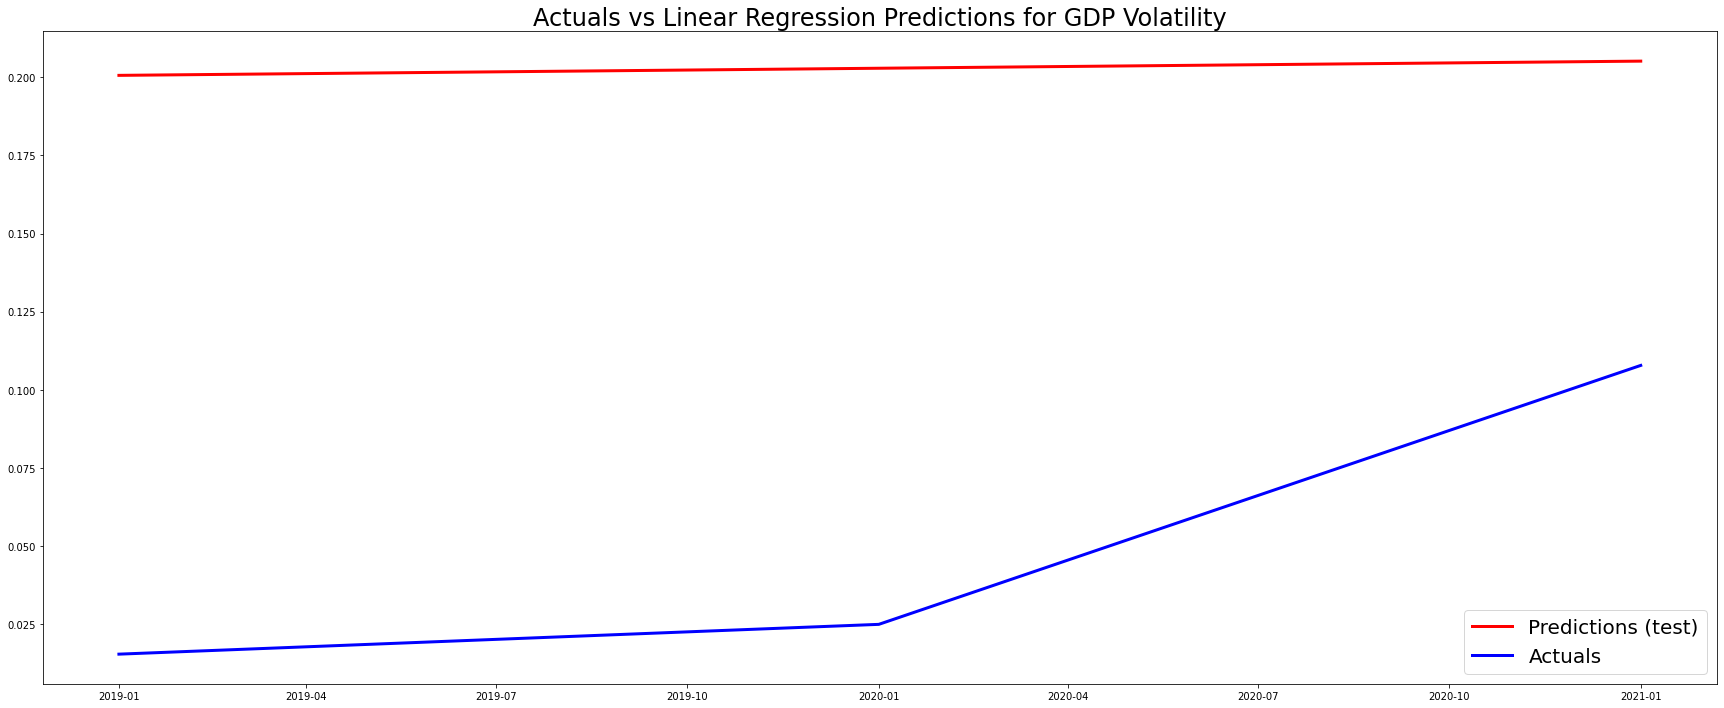

In [82]:
print(f"{mse=:.3f}")
plot_forecast(df_test, full=False)
plt.title("Actuals vs Linear Regression Predictions for GDP Volatility")
plt.show()

Модель GARCH, ожидаемо, работает немного лучше линейной регрессии.

Попробуем модель Prophet.

In [144]:
df = df.reset_index()

In [145]:
df.columns = ["ds", "y"]

In [146]:
df.head()

,ds,y
0,1960-01-01,NaN
1,1961-01-01,0.067894
2,1962-01-01,0.063578
3,1963-01-01,0.114488
4,1964-01-01,0.123636


In [147]:
df_train = df.iloc[:-3]
df_test = df.iloc[-3:]

In [148]:
model = Prophet()

In [149]:
model.fit(df_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmptddoqfd0/zqh8897l.json
DEBUG:cmdstanpy:input tempfile: /var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmptddoqfd0/9qftbulg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33560', 'data', 'file=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmptddoqfd0/zqh8897l.json', 'init=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmptddoqfd0/9qftbulg.json', 'output', 'file=/var/folders/td/2zhlxcg531n6ttp901cv66lc0000gp/T/tmptddoqfd0/prophet_modelagwid82v/prophet_model-20230127094528.csv', 'method=optimize', 'algorith

In [150]:
df_pred = model.predict(df[["ds"]])[["ds", "yhat", "yhat_lower", "yhat_upper"]]

In [151]:
df_pred.tail()

,ds,yhat,yhat_lower,yhat_upper
57,2017-01-01,0.207121,0.064775,0.385614
58,2018-01-01,0.205285,0.029355,0.365346
59,2019-01-01,0.196055,0.036300,0.359113
60,2020-01-01,0.179445,0.025040,0.351829
61,2021-01-01,0.215780,0.050563,0.376506


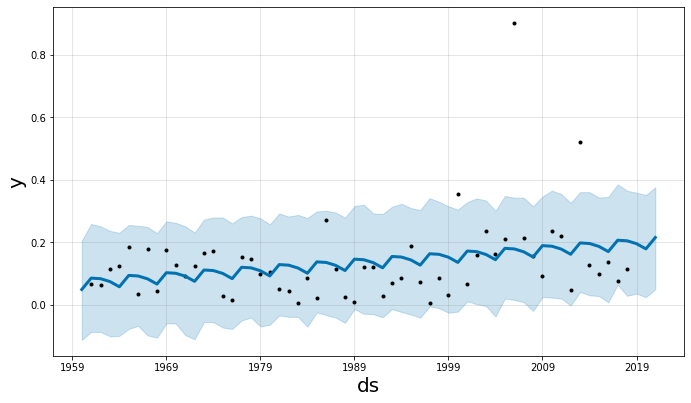

In [152]:
# вся модель выглядет так
fig = model.plot(df_pred)

In [153]:
df = df.set_index("ds")
df_train = df_train.set_index("ds")
df_test = df_test.set_index("ds")
df_pred = df_pred.set_index("ds")

df_pred.insert(0, "y_true", df["y"])

In [154]:
mse = round(mean_squared_error(df_test["y"], df_pred.iloc[-3:]["yhat"]), 3)

mse=0.023


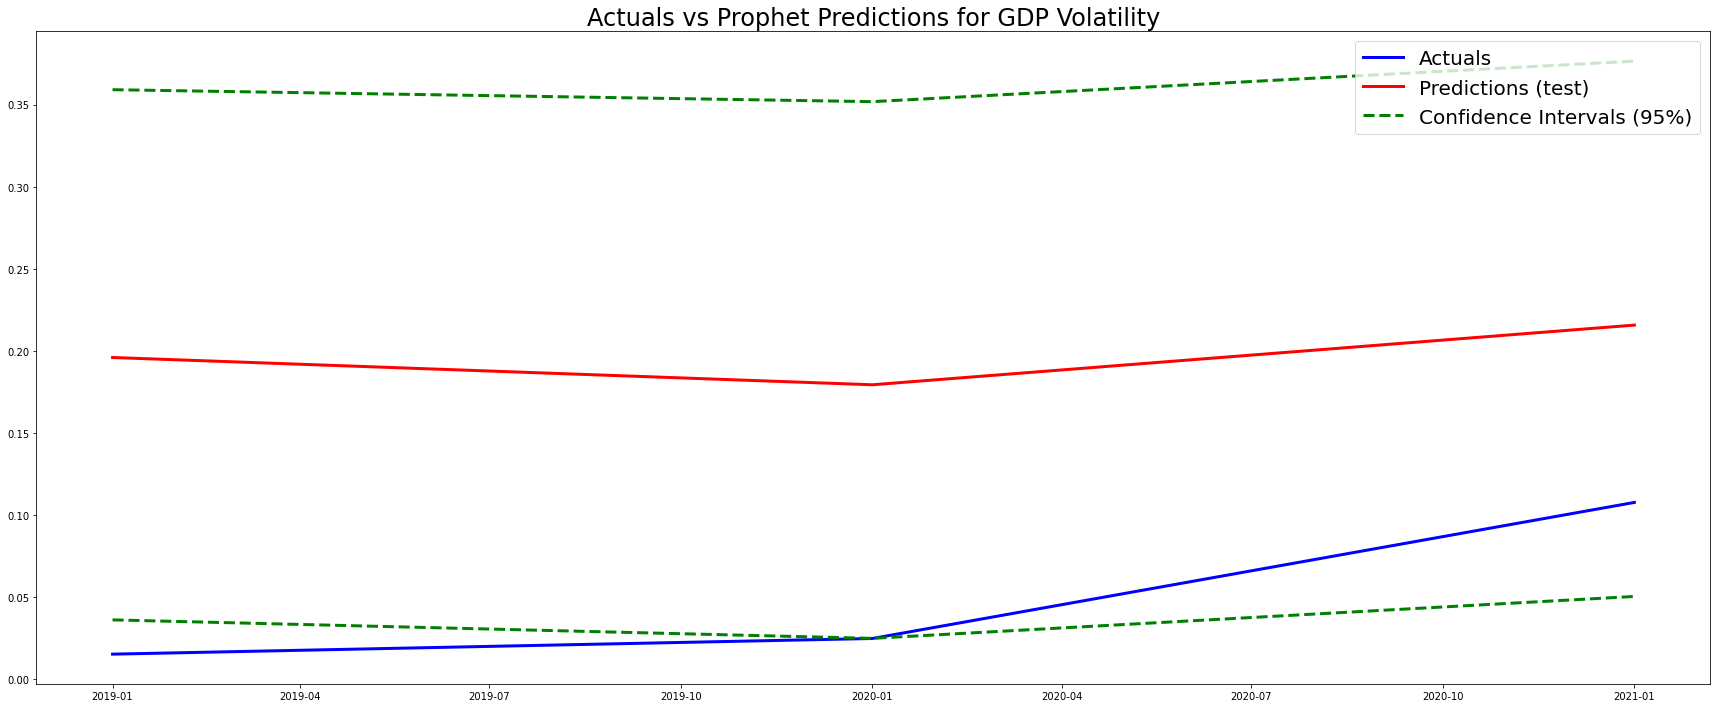

In [155]:
print(f"{mse=:.3f}")
plot_forecast(df_pred, full=False)
plt.title("Actuals vs Prophet Predictions for GDP Volatility")
plt.show()

MSE немного хуже, чем у модели GARCH. С другой стороны, это единственная модель, которая уловила перегиб в средней точке наших тестовых данных.